In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from yahoofinancials import YahooFinancials

In [2]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));

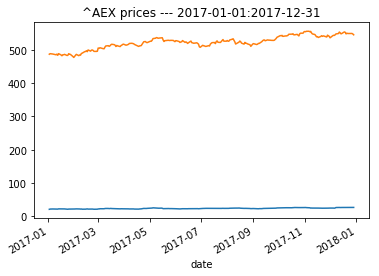

In [3]:
tickers=['ABN.AS', '^AEX']

for ticker in tickers:
    download_csv_data(ticker=ticker, 
                      start_date='2017-01-01', 
                      end_date='2017-12-31', 
                      freq='daily', 
                      path='european/daily/'+ticker.strip(' .^')+'.csv')
    df=None

In [5]:
from zipline.data import bundles
from zipline.data.bundles.csvdir import csvdir_equities
import os

start_session = pd.Timestamp('2017-01-02', tz='utc')
end_session = pd.Timestamp('2017-12-29', tz='utc')

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(),'european')
# Create an ingest function 
ingest_func = csvdir_equities(['daily'], os.environ['ZIPLINE_ROOT'])

# Register the data bundle and its ingest function
bundles.register('eu_stocks', ingest_func, 
                 calendar_name='XAMS',  # Euronext Amsterdam
                start_session=start_session,
                end_session=end_session);

In [6]:
bundles.ingest('eu_stocks')


 | ABN.AS: sid 0
 | AEX: sid 1


In [87]:
bundle_data = bundles.load('eu_stocks')

### Algorithm

In [88]:
from zipline.api import order, symbol, record, set_benchmark
import zipline
from zipline.algorithm import TradingAlgorithm

# parameters
selected_stock = 'ABN.AS'
n_stocks_to_buy = 10

def initialize(context):
    set_benchmark(symbol('AEX'))
    context.asset = symbol('ABN.AS')
    context.has_ordered = False  

def handle_data(context, data):
    # record price for further inspection
    record(price=data.current(symbol(selected_stock), 'price'))
    record(AEX=data.current(symbol('AEX'), 'price'))
    
    # trading logic
    if not context.has_ordered:
        # placing order, negative number for sale/short
        order(symbol(selected_stock), n_stocks_to_buy)
        # setting up a flag for holding a position
        context.has_ordered = True

To now test this algorithm on financial data, zipline provides three interfaces: A command-line interface, IPython Notebook magic, and run_algorithm().

### Ipython notebook magic method to execute

In [84]:
%load_ext zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [70]:
%zipline --start 2017-1-2 --end 2017-12-29 --capital-base 250 --bundle eu_stocks -o buy_and_hold.pkl --trading-calendar XAMS


,AEX,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-01-02 16:30:00+00:00,486.369,NaN,0.000000,NaN,0.010826,NaN,NaN,0.00000,250.00000,0.00,...,0.0,0.0,0,NaN,250.00000,0.00,0.00,1,[],0.0
2017-01-03 16:30:00+00:00,487.989,0.005377,-0.000479,-0.174350,0.014193,0.084132,0.063908,-219.61975,30.38025,219.50,...,0.0,0.0,0,-11.224972,250.00000,0.00,0.00,2,[{'order_id': '32e9b584cdc3460a8b75df25b0fb75f...,0.0
2017-01-04 16:30:00+00:00,487.579,0.066491,0.006521,1.131266,0.013341,0.093841,-0.521389,0.00000,30.38025,221.25,...,0.0,0.0,0,124.836530,30.38025,219.50,219.50,3,[],0.0
2017-01-05 16:30:00+00:00,486.929,0.056968,0.006521,0.626082,0.011990,0.089273,-0.284848,0.00000,30.38025,221.25,...,0.0,0.0,0,108.111606,30.38025,221.25,221.25,4,[],0.0
2017-01-06 16:30:00+00:00,487.000,0.052435,0.010681,0.734502,0.012137,0.079917,-0.322860,0.00000,30.38025,222.29,...,0.0,0.0,0,157.954187,30.38025,221.25,221.25,5,[],0.0
2017-01-09 16:30:00+00:00,485.100,0.088772,0.001081,-0.024659,0.008189,0.082406,0.212205,0.00000,30.38025,219.89,...,0.0,0.0,0,0.789670,30.38025,222.29,222.29,6,[],0.0
2017-01-10 16:30:00+00:00,484.739,0.083570,0.004681,0.127588,0.007438,0.076290,0.161802,0.00000,30.38025,220.79,...,0.0,0.0,0,2.999786,30.38025,219.89,219.89,7,[],0.0
2017-01-11 16:30:00+00:00,486.579,0.078082,0.003481,0.068195,0.011262,0.072269,0.123732,0.00000,30.38025,220.49,...,0.0,0.0,0,2.084812,30.38025,220.79,220.79,8,[],0.0
2017-01-12 16:30:00+00:00,483.089,0.085439,-0.004479,-0.167120,0.004009,0.081440,0.388791,0.00000,30.38025,218.50,...,0.0,0.0,0,-1.859323,30.38025,220.49,220.49,9,[],0.0
2017-01-13 16:30:00+00:00,488.089,0.164500,0.023481,0.187382,0.014401,0.091445,1.125972,0.00000,30.38025,225.49,...,0.0,0.0,0,9.567916,30.38025,218.50,218.50,10,[],0.0


### run_algorithm() method to execute

If using some other stock like eg. European here, make sure to use proper trading_calendar or it would through error.

In [82]:
from datetime import datetime
from trading_calendars import get_calendar
import pytz
perf = zipline.run_algorithm(start=datetime(2017, 1, 2, 0 , 0, 0, 0, pytz.utc),
                      end=datetime(2017, 12, 29,0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      bundle='eu_stocks',
                      trading_calendar=get_calendar('XAMS'))
perf

,AEX,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-01-02 16:30:00+00:00,486.369,NaN,0.000000e+00,NaN,0.010826,NaN,NaN,0.00000,100000.00000,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,1,[],0.0
2017-01-03 16:30:00+00:00,487.989,0.000013,-1.197500e-06,-0.000436,0.014193,0.084132,0.000160,-219.61975,99780.38025,219.50,...,0.0,0.0,0,-11.224972,100000.00000,0.00,0.00,2,[{'order_id': '088a92ff38e240768803998cde33ca2...,0.0
2017-01-04 16:30:00+00:00,487.579,0.000166,1.630250e-05,0.002827,0.013341,0.093841,-0.001303,0.00000,99780.38025,221.25,...,0.0,0.0,0,124.772503,99780.38025,219.50,219.50,3,[],0.0
2017-01-05 16:30:00+00:00,486.929,0.000142,1.630250e-05,0.001564,0.011990,0.089273,-0.000712,0.00000,99780.38025,221.25,...,0.0,0.0,0,108.056157,99780.38025,221.25,221.25,4,[],0.0
2017-01-06 16:30:00+00:00,487.000,0.000131,2.670250e-05,0.001840,0.012137,0.079917,-0.000808,0.00000,99780.38025,222.29,...,0.0,0.0,0,158.303039,99780.38025,221.25,221.25,5,[],0.0
2017-01-09 16:30:00+00:00,485.100,0.000223,2.702500e-06,-0.000073,0.008189,0.082406,0.000540,0.00000,99780.38025,219.89,...,0.0,0.0,0,0.729004,99780.38025,222.29,222.29,6,[],0.0
2017-01-10 16:30:00+00:00,484.739,0.000210,1.170250e-05,0.000310,0.007438,0.076290,0.000413,0.00000,99780.38025,220.79,...,0.0,0.0,0,2.922185,99780.38025,219.89,219.89,7,[],0.0
2017-01-11 16:30:00+00:00,486.579,0.000196,8.702500e-06,0.000161,0.011262,0.072269,0.000318,0.00000,99780.38025,220.49,...,0.0,0.0,0,2.017095,99780.38025,220.79,220.79,8,[],0.0
2017-01-12 16:30:00+00:00,483.089,0.000215,-1.119750e-05,-0.000426,0.004009,0.081440,0.000979,0.00000,99780.38025,218.50,...,0.0,0.0,0,-1.890290,99780.38025,220.49,220.49,9,[],0.0
2017-01-13 16:30:00+00:00,488.089,0.000411,5.870250e-05,0.000455,0.014401,0.091445,0.002812,0.00000,99780.38025,225.49,...,0.0,0.0,0,9.402041,99780.38025,218.50,218.50,10,[],0.0
